# Proyek Machine Learning - Recommender System

# Data Diri

- Nama : Faisal Ahmad Gifari
- Jenis Kelamin : Laki-Laki
- Pekerjaaan : Mahasiswa
- Tempat/Tanggal Lahir : Kuningan, 17 September 2002
- Username : faisal_ag_037
- email : pd-20379543@edu.jakarta.go.id
- No. Telepon : 085775063559
- Kota Domisili : Jakarta Barat
- Institusi : UIN Syarif Hidayatullah Jakarta


# Importing Library

In [1]:
import tensorflow
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
from zipfile import ZipFile
from tensorflow import keras
from keras import layers
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Importing Datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
movie_df = pd.read_csv('/content//drive/MyDrive/Datasets/movies.csv')
review_df = pd.read_csv('/content/drive/MyDrive/Datasets/ratings.csv')

Kedua sudah berhasil di-import kedalam notebook.

- `movies.csv` menjadi dataframe dengan nama `movie_df`
- `reviews.csv` menjadi dataframe dengan nama `review_df`

In [4]:
movie_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
review_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Kedua dataframe telah berhasil dibuat.

# Data Undestanding

Dataset yang digunakan untuk pembuatan model system recommendation ini adalah dataset "MovieLens Latest" yang tersedia di situs [grouplens](https://grouplens.org/datasets/movielens/) yang berisi data-data mengenai film-film beserta rating yang diberikan oleh para pengguna. Dataset ini terakhir di-update pada September 2018

Terdapat banyak file didalamnya, tetapi yang digunakan hanya dataset `movie.csv` dan `rating.csv`. `movie.csv` terdiri dari 9078 baris data dan 3 kolom data. Kemudian, `rating.csv` terdiri dari 100836 baris data dan 4 kolom data.

Kedua dataset tersebut dapat digunakan untuk membuat system recommendation, baik `Content-Based Filtering` maupun `Collaborative Filtering`

Dataset tersebut dapat diunduh [disini](https://grouplens.org/datasets/movielens/)

[Direct download](https://files.grouplens.org/datasets/movielens/ml-latest-small.zip)

Berikut ini adalah infomasi lainnya mengenai atribut-atribut yang terdapat pada dua dataset tersebut:


Atribut-atribut pada `movie.csv`:
- ```movieId```: Id film
- ```title```: Judul film
- ```genres```: Genre film


Atribut-atribut pada `rating.csv` :
- ```userId```: Id user
- ```movieId```: Id film
- ```rating```: Skor rating yang sebuah film
- ```timestamp```: Waktu kapan film diberikan skor rating


## Exploratory Data Analysis

Exploratory Data Analysis (EDA) adalah pendekatan analisis data yang bertujuan untuk memahami karakteristik utama dari kumpulan data. EDA melibatkan penggunaan teknik statistik dan visualisasi grafis untuk menemukan pola, hubungan, atau anomali untuk membentuk hipotesis. Proses ini sering kali tidak terstruktur dan dianggap sebagai langkah awal penting dalam analisis data yang membantu menentukan arah analisis lebih lanjut.

### movie_df

In [6]:
# Menampilan jumlah baris dan kolom yang ada pada dataset

movie_df.shape

(9742, 3)

Berdasarkan output diatas, `movie_df` memiliki:
- 9742 baris data
- 3 kolom data

In [7]:
# Menampilkan kolom-kolom yang ada pada dataset

movie_df.keys()

Index(['movieId', 'title', 'genres'], dtype='object')

Berdasarkan output diatas, `movie_df` memiliki 3 kolom berbeda, yaitu:
- `movieId`
- `title`
- `genres`

In [8]:
# Menampilkan tipe data dari setiap kolom yang ada

movie_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Berdasarkan output diatas, `movie_df` memiliki 3 kolom tersebut memiliki tipe datanya masing-masing, yaitu:
- `movieId` = `int64`
- `title` = `object`
- `genres` = `object`

In [9]:
# Menampilkann total unique value di kolom movieId

print(movie_df['movieId'].nunique())

9742


In [10]:
# Menampilkan total unique value di kolom genre dan mencetak setiap value-nya

unique_genres = movie_df['genres'].unique()
for genre in unique_genres:
    print(genre)


Adventure|Animation|Children|Comedy|Fantasy
Adventure|Children|Fantasy
Comedy|Romance
Comedy|Drama|Romance
Comedy
Action|Crime|Thriller
Adventure|Children
Action
Action|Adventure|Thriller
Comedy|Horror
Adventure|Animation|Children
Drama
Action|Adventure|Romance
Crime|Drama
Drama|Romance
Action|Comedy|Crime|Drama|Thriller
Comedy|Crime|Thriller
Crime|Drama|Horror|Mystery|Thriller
Drama|Sci-Fi
Children|Drama
Adventure|Drama|Fantasy|Mystery|Sci-Fi
Mystery|Sci-Fi|Thriller
Children|Comedy
Drama|War
Action|Crime|Drama
Action|Adventure|Fantasy
Comedy|Drama|Thriller
Mystery|Thriller
Animation|Children|Drama|Musical|Romance
Crime|Mystery|Thriller
Adventure|Drama
Drama|Thriller
Comedy|Crime
Action|Sci-Fi|Thriller
Action|Comedy|Horror|Thriller
Comedy|Drama
Documentary
Action|Crime|Drama|Thriller
Crime|Drama|Romance
Action|Adventure|Drama
Action|Thriller
Drama|Horror|Thriller
Comedy|Horror|Romance
Adventure|Comedy|Crime|Romance
Adventure|Children|Comedy|Musical
Action|Drama|War
Crime|Drama|Thriller

Berdasarkan output diatas, `movie_df` memiliki terlalu banyak `genre` nyaris untuk setiap film-nya. Hal ini perlu disimplifikasikan untuk memudahkan tahap-tahap lainnya.

In [11]:
movie_df['genres'] = movie_df['genres'].str.split('|').str[0]


Kode diatas membuat kolom 'genre' hanya mempertahankan genre yang berada padaa urutan pertama saja. Hal ini mempermudah untuk pemrosesan dataset pada tahap-tahap selanjutnya.

In [12]:
# Menampilkan total unique value di kolom genre dan mencetak setiap value-nya

unique_genres = movie_df['genres'].unique()
for genre in unique_genres:
    print(genre)


Adventure
Comedy
Action
Drama
Crime
Children
Mystery
Animation
Documentary
Thriller
Horror
Fantasy
Western
Film-Noir
Romance
Sci-Fi
Musical
War
(no genres listed)


In [13]:
movie_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure
1,2,Jumanji (1995),Adventure
2,3,Grumpier Old Men (1995),Comedy
3,4,Waiting to Exhale (1995),Comedy
4,5,Father of the Bride Part II (1995),Comedy


Proses perubahan nilai pada kolom `genre` sudah berhasil dilakukan.



In [14]:
movie_df.rename(columns={'genres': 'genre'}, inplace=True)

Nama kolom `genres` berhasil diganti menjadi `genre` karena genre dari tiap film sudah tidak ada yang lebih dari 1

Namun, Masih ada beberapa tindakan yang perlu dilakukan untuk membersihkan `movie_df`. Proses pembersihan dan persiapan dataset akan dikerjakan lebih lanjut pada tahap selanjutnya.

### review_df

In [15]:
# Menampilan jumlah baris dan kolom yang ada pada dataset

review_df.shape

(100836, 4)

Berdasarkan output diatas, `review_df` memiliki:
- 100836 baris data
- 4 kolom data

In [16]:
# Menampilkan kolom-kolom yang ada pada dataset

review_df.keys()

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

Berdasarkan output diatas, `review_df` memiliki 4 kolom berbeda, yaitu:
- `userId`
- `movieId`
- `review`
- `timestamp`

In [17]:
review_df.rename(columns={'rating': 'review'}, inplace=True)


Tahap diatas adalah pengubahan nama kolom yang sebelumnya `review` menjadi `review` untuk memudahkan karena sesuai dengan nama dataframe-nya yaitu `review_df`

In [18]:
# Menampilkan kolom-kolom yang ada pada dataset

review_df.keys()

Index(['userId', 'movieId', 'review', 'timestamp'], dtype='object')

Berdasarkan output diatas, proses pengubahan nama kolom `review` menjadi `review` telah berhasil dilakukan

In [19]:
# Menampilkan tipe data dari setiap kolom yang ada

review_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   review     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


Berdasarkan output diatas, `review_df` memiliki 4 kolom berbeda dengan tipe datanya masing-masing, yaitu:
- `userId` = `int64`
- `movieId` = `int64`
- `review` = `float64`
- `timestamp` = `int64`

In [20]:
review_df['review'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: review, dtype: float64

Fungsi diatas memberikan informasi statistika deskriptif untuk kolom `review`, yaitu:
- ```count``` : Jumlah data dari sebuah kolom
- ```mean``` : Rata-rata dari sebuah kolom
- ```std``` : Standar deviasi dari sebuah kolom
- ```min``` : Nilai terendah pada sebuah kolom
- ```25%``` : Nilai kuartil pertama (Q1) dari sebuah kolom
- ```50%``` : Nilai kuartil kedua (Q2) atau median atau nilai tengah dari sebuah kolom
- ```75%``` : Nilai kuartil ketiha (Q3) dari sebuah kolom
- ```max``` : Nilai tertinggi pada sebuah kolom

Walaupun kolom selain `review` ada yang tetap bisa diproses menggunakan fungsi `describe()` karena bertipe data `int64` dan `float64`, tetapi yang benar-benar kolom numerik hanyalah kolom `review`.

In [21]:
# Menampilakn total unique value di kolom movieId

print(review_df['movieId'].nunique())

9724


Berdasarkan output diatas, `review_df` memiliki 9724 `movieId` secara unique dari keseluruhan dataset.

In [24]:
# Menampilakn total unique value di kolom user

print(review_df['userId'].nunique())

610


Berdasarkan output diatas, `review_df` memiliki 610 `userId` secara unique dari keseluruhan dataset. Hal ini berarti ada 610 user yang memberikan review terhadap film-film yang mereka telah tonton.

## Data Visualization

Visualisasi data adalah proses representasi grafis dari informasi dan data. Dengan menggunakan elemen visual seperti grafik, diagram, dan peta, visualisasi data menyediakan cara yang intuitif dan mudah diakses untuk melihat dan memahami tren, anomali, dan pola dalam data. Tujuan utama dari visualisasi data adalah untuk mengkomunikasikan informasi secara jelas dan efisien kepada pengguna, sehingga memudahkan pemahaman, analisis, dan pengambilan keputusan berdasarkan data tersebut

### movie_df

Univariate Analysis <br>

Univariate Analysis adalah jenis analisis data yang memeriksa satu variabel (atau bidang data) pada satu waktu. Tujuannya adalah untuk menggambarkan data dan menemukan pola yang ada dalam distribusi variabel tersebut. Ini termasuk penggunaan statistik deskriptif, histogram, dan box plots untuk menganalisis distribusi dan memahami sifat dari variabel tersebut.


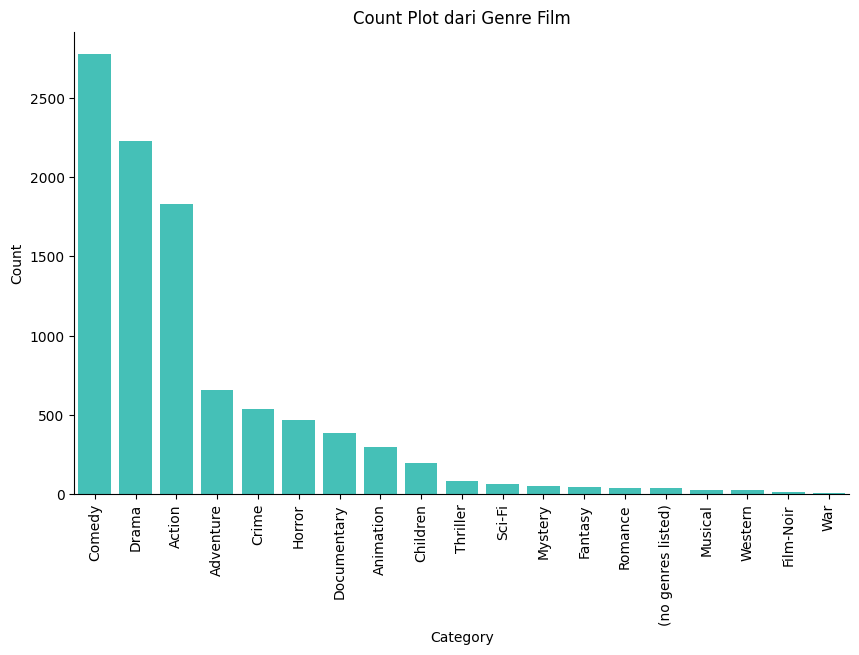

In [25]:
plt.figure(figsize=(10, 6))
genre_counts = movie_df['genre'].value_counts()
genre_counts_sorted = genre_counts.sort_values(ascending=False)
sns.countplot(x='genre', data=movie_df, color='#30D5C8', order=genre_counts_sorted.index)
sns.despine()
plt.title('Count Plot dari Genre Film')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


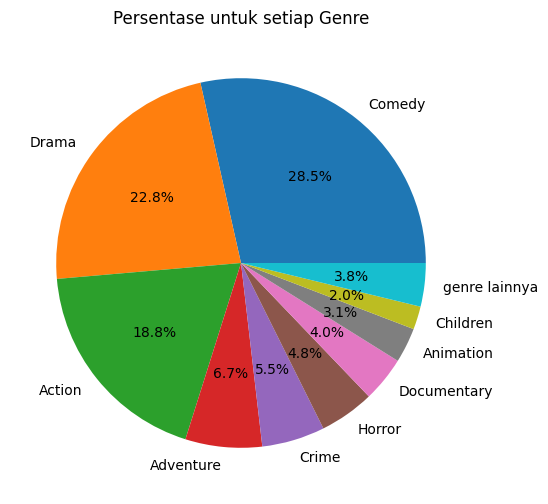

In [26]:
# Calculate the percentage of each genre
genre_percentages = genre_counts_sorted / genre_counts_sorted.sum() * 100

# Filter genres with a percentage below 1%
low_percentage_genres = genre_percentages[genre_percentages < 1]

# Combine low percentage genres as 'genre lainnya'
genre_percentages['genre lainnya'] = low_percentage_genres.sum()

# Remove low percentage genres from the original series
genre_percentages = genre_percentages.drop(low_percentage_genres.index)

# Plot the pie chart
plt.figure(figsize=(10, 6))
plt.pie(genre_percentages, labels=genre_percentages.index, autopct='%1.1f%%')
plt.title('Persentase untuk setiap Genre')
plt.show()


Berdasarkan visualisasi data diatas, terlihat bahwa `Comedy`, `Drama`, dan `Action` memiliki proporsi dan jumlah terbesar secara keseluruhan dibandingkan genre lainnya pada `movie_df`

Namun, ada beberapa genre yang terlihat terlampau sedikit. Hal ini perlu untuk dicek lebih lanjut.

### review_df

Univariate Analysis

Univariate Analysis <br>

Univariate Analysis adalah jenis analisis data yang memeriksa satu variabel (atau bidang data) pada satu waktu. Tujuannya adalah untuk menggambarkan data dan menemukan pola yang ada dalam distribusi variabel tersebut. Ini termasuk penggunaan statistik deskriptif, histogram, dan box plots untuk menganalisis distribusi dan memahami sifat dari variabel tersebut.


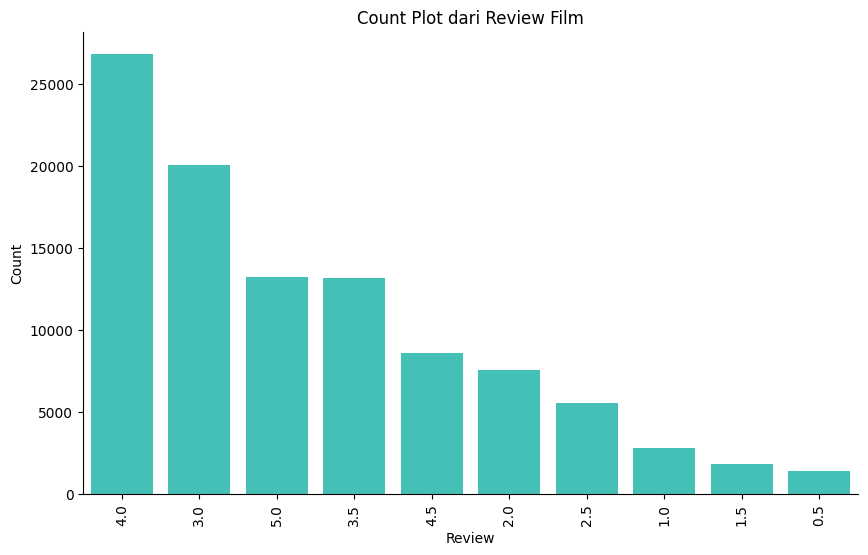

In [27]:
plt.figure(figsize=(10, 6))
review_counts = review_df['review'].value_counts()
review_counts_sorted = review_counts.sort_values(ascending=False)
sns.countplot(x='review', data=review_df, color='#30D5C8', order=review_counts_sorted.index)
sns.despine()
plt.title('Count Plot dari Review Film')
plt.xlabel('Review')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


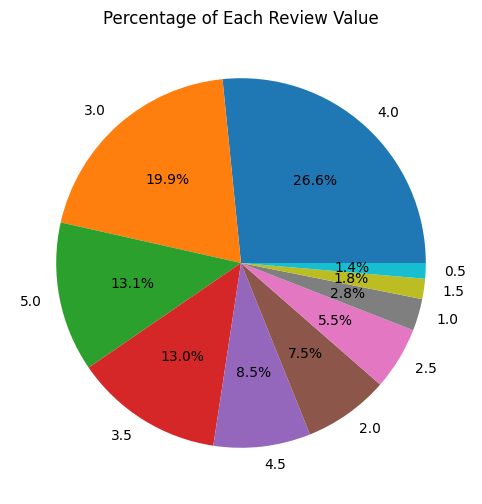

In [28]:
review_percentages = review_df['review'].value_counts(normalize=True) * 100
plt.figure(figsize=(8, 6))
review_percentages.plot.pie(autopct='%1.1f%%')
plt.title('Percentage of Each Review Value')
plt.ylabel('')
plt.show()


Berdasarkan visualisasi data diatas, terlihat bahwa `4.0` dan `3.0` memiliki proporsi dan jumlah terbesar secara keseluruhan dibandingkan skor lainnya pada `review_df`.

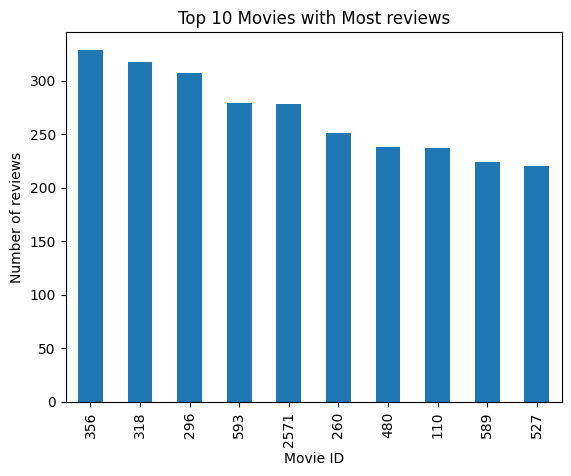

In [29]:
top_10_movies = review_df['movieId'].value_counts().head(10)
top_10_movies.plot(kind='bar')
plt.title('Top 10 Movies with Most reviews')
plt.xlabel('Movie ID')
plt.ylabel('Number of reviews')
plt.show()


Berdasarkan visualisasi data diatas, berikut adalah daftar `movieId` dengan review terbanyak pada dataset `review_df`.

In [30]:
top_10_movies_array = top_10_movies.index.to_numpy()
print(top_10_movies_array)

[ 356  318  296  593 2571  260  480  110  589  527]


In [31]:
movie_df[movie_df['movieId'].isin(top_10_movies_array)]

,movieId,title,genre
97,110,Braveheart (1995),Action
224,260,Star Wars: Episode IV - A New Hope (1977),Action
257,296,Pulp Fiction (1994),Comedy
277,318,"Shawshank Redemption, The (1994)",Crime
314,356,Forrest Gump (1994),Comedy
418,480,Jurassic Park (1993),Action
461,527,Schindler's List (1993),Drama
507,589,Terminator 2: Judgment Day (1991),Action
510,593,"Silence of the Lambs, The (1991)",Crime
1939,2571,"Matrix, The (1999)",Action


Output diatas adalah 10 judul dari film-film yang memiliki jumlah review terbanyak.

# Data Preparation

## movie_df

In [32]:
movie_df

,movieId,title,genre
0,1,Toy Story (1995),Adventure
1,2,Jumanji (1995),Adventure
2,3,Grumpier Old Men (1995),Comedy
3,4,Waiting to Exhale (1995),Comedy
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action
9738,193583,No Game No Life: Zero (2017),Animation
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action


### Detection and Removal Duplicates

Data duplikat adalah baris data yang sama persis untuk setiap variabel yang ada. Dataset yang digunakan perlu diperiksa juga apakah dataset memiliki data yang sama atau data duplikat. Jika ada, maka data tersebut harus ditangani dengan menghapus data duplikat tersebut.

**Alasan**: Data duplikat perlu didektesi dan dihapus karena jika dibiarkan pada dataset dapat membuat model Anda memiliki bias, sehingga menyebabkan _overfitting_. Dengan kata lain, model memiliki performa akurasi yang baik pada data pelatihan, tetapi buruk pada data baru. Menghapus data duplikat dapat membantu memastikan bahwa model Anda dapat menemukan pola yang ada lebih baik lagi.

In [33]:
# Cek baris duplikat dalam dataset
duplicates_movie = movie_df.duplicated()

# Hitung jumlah baris duplikat
duplicate_count = duplicates_movie.sum()

# Cetak jumlah baris duplikat
print(f"Number of duplicate rows: {duplicate_count}")


Number of duplicate rows: 0


Berdasarkan hasil tersebut, tidak ditemukan adanya data duplikat, maka tidak ada juga proses penghapusannya.

### Handle Missing Value

_Missing Value_ terjadi ketika variabel atau barus tertentu kekurangan titik data, sehingga menghasilkan informasi yang tidak lengkap. Nilai yang hilang dapat ditangani dengan berbagai cara seperti imputasi (mengisi nilai yang hilang dengan mean, median, modus, dll), atau penghapusan (menghilangkan baris atau kolom yang nilai hilang)

**Alasan**: _Missing Value_ perlu ditangani karena jika dibiarkan dapat berpengaruh ke rendahnya akurasi model yang akan dibuat. Maka dari itu, penting untuk mengatasi missing value secara efisien untuk mendapatkan model _Machine Learning_ yang baik juga.

In [34]:
movie_df.isnull().sum()

movieId    0
title      0
genre      0
dtype: int64

Berdasarkan output diatas, tidak adanya missing value pada `movie_df`

### Delete Some Data Point

Pada sebuah dataset, ada saatnya beberapa baris data atau kolom perlu dihapus karena satu dan lain hal. Salah satunya agar tidak menghambat proses training dan performa dari sebuah model yang akan dibangun. Ada value pada dataset `movie_df`, khususnya kolom `genre`, yang perlu dihapus karena nama nilainya itu sendiri, yaitu `(no genres listed)'.

**Alasan**: Hal ini perlu dilakukan karena nilai tersebut tidak mewakili genre apapun untuk sebuah film. Jika dibiarkan, ini dapat mempengaruhi performa model yang akan dibuat. Maka dari itu, baris data yang memiliki nilai ini, perlu dihapus

In [35]:
movie_df.drop(movie_df[movie_df['genre'] == '(no genres listed)'].index, inplace=True)

`(no genres listed)` sudah dihapus dari kolom `genre`

In [36]:
# Menampilkan total unique value di kolom genre dan mencetak setiap value-nya

unique_genres = movie_df['genre'].unique()
for genre in unique_genres:
    print(genre)

Adventure
Comedy
Action
Drama
Crime
Children
Mystery
Animation
Documentary
Thriller
Horror
Fantasy
Western
Film-Noir
Romance
Sci-Fi
Musical
War


Berdasarkan outpur diatas, `(no genres listed)` terbukti sudah tidak ada lagi pada dataset

In [37]:
value_counts = movie_df['genre'].value_counts()

# Filter the counts to find values that occur less than 6 times
less_than_six = value_counts[value_counts < 6]

# Print the result
print("Values with less than 6 data points:")
print(less_than_six)

Values with less than 6 data points:
War    4
Name: genre, dtype: int64


Berdasarkan output diatas, `War` pada kolom `genre` hanya memiliki 4 data point. Dalam kasus ini, value yang kurang dari 6 data dalam dataset perlu dihilangkana karena tidak dapat digunakan. Hal ini akan ditindak lebih lanjut pada bagian selanjutnya.

In [38]:
movie_df = movie_df[~movie_df['genre'].str.contains('War')]


Berhasil dilakukannya penghapusan data point pada kolon `genre` yang bernilai `War`

### Changing Certain Value

Pada sebuah dataset, ada kalanya beberapa nilai perlu diproses terlebih dahulu agar proses training atau pembuatan model dapat berjalan seperti seharusnya. Salah satunya adalah pengubahan beberapa nilai yang dirasa akan mengganggu jika dibiarkan. Ada value pada dataset `movie_df`, khususnya kolom `genre`, yang perlu diganti namanya, yaitu `Sci-Fi` dan `Film-Noir`.

**Alasan**: Hal ini perlu dilakukan karena jika dibiarkan ketika proses embedding akan terdeteksi sebagai 2 bagian yang berbeda. Maka dari itu, string dari kedua nilai tersebut harus dimodifikasi agar pada saat proses encoding tidak terpecah menjadi 2 bagian berbeda.

In [39]:
movie_df['genre'] = movie_df['genre'].replace({'Sci-Fi': 'SciFi', 'Film-Noir': 'FilmNoir'})

<ipython-input-39-063e1859e63e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df['genre'] = movie_df['genre'].replace({'Sci-Fi': 'SciFi', 'Film-Noir': 'FilmNoir'})


nilai `Sci-Fi` dan `Film-Noir` sudah berhasil diubah dengan menghilangkan tanda `-` pada kedua nilai tersebut. Maka dari itu, nilai tersebut sudah siap untuk diproses pada tahap selanjutnya.

In [40]:
# Menampilkan total unique value di kolom genre dan mencetak setiap value-nya

unique_genres = movie_df['genre'].unique()
for genre in unique_genres:
    print(genre)

Adventure
Comedy
Action
Drama
Crime
Children
Mystery
Animation
Documentary
Thriller
Horror
Fantasy
Western
FilmNoir
Romance
SciFi
Musical


Berdasarkan output diatas, dapat dilihat bahwa sudah terlihat nilai yang baru saja diubah, yaitu `SciFi` dan `FilmNoir`

In [41]:
movie_df.shape

(9704, 3)

Setelah beberapa proses yang sudah dilakukan, maka `movie_df` masih memiliki:
- 9708 baris data
- 3 kolom data

## review_df

In [42]:
review_df

,userId,movieId,review,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


### Detection and Removal Duplicates

Data duplikat adalah baris data yang sama persis untuk setiap variabel yang ada. Dataset yang digunakan perlu diperiksa juga apakah dataset memiliki data yang sama atau data duplikat. Jika ada, maka data tersebut harus ditangani dengan menghapus data duplikat tersebut.

**Alasan**: Data duplikat perlu didektesi dan dihapus karena jika dibiarkan pada dataset dapat membuat model Anda memiliki bias, sehingga menyebabkan _overfitting_. Dengan kata lain, model memiliki performa akurasi yang baik pada data pelatihan, tetapi buruk pada data baru. Menghapus data duplikat dapat membantu memastikan bahwa model Anda dapat menemukan pola yang ada lebih baik lagi.

In [43]:
# Cek baris duplikat dalam dataset
duplicates_review = review_df.duplicated()

# Hitung jumlah baris duplikat
duplicate_review = duplicates_movie.sum()

# Cetak jumlah baris duplikat
print(f"Number of duplicate rows: {duplicate_review}")


Number of duplicate rows: 0


Berdasarkan hasil tersebut, tidak ditemukan adanya data duplikat, maka tidak ada juga proses penghapusannya.

### Handle Missing Value

_Missing Value_ terjadi ketika variabel atau barus tertentu kekurangan titik data, sehingga menghasilkan informasi yang tidak lengkap. Nilai yang hilang dapat ditangani dengan berbagai cara seperti imputasi (mengisi nilai yang hilang dengan mean, median, modus, dll), atau penghapusan (menghilangkan baris atau kolom yang nilai hilang)

**Alasan**: _Missing Value_ perlu ditangani karena jika dibiarkan dapat berpengaruh ke rendahnya akurasi model yang akan dibuat. Maka dari itu, penting untuk mengatasi missing value secara efisien untuk mendapatkan model _Machine Learning_ yang baik juga.

In [44]:
review_df.isnull().sum()

userId       0
movieId      0
review       0
timestamp    0
dtype: int64

Berdasarkan output diatas, tidak adanya missing value pada `review_df`. Maka, tidak perlu dilakukan pengisian pada data hilang.

### Outliers Detection and Removal


_Outliers_ adalah titik data yang secara signifikan berbeda dari sebagian besar data dalam kumpulan data. Outliers dapat muncul karena variasi dalam pengukuran atau mungkin menunjukkan kesalahan eksperimental; dalam beberapa kasus, outliers bisa juga menunjukkan variabilitas yang sebenarnya dalam data. Penting untuk menganalisis outliers karena mereka dapat memiliki pengaruh besar pada hasil analisis statistik.

Outliers adalah titik data yang secara signifikan berbeda dari sebagian besar data dalam kumpulan data. Outliers dapat muncul karena variasi dalam pengukuran atau mungkin menunjukkan kesalahan eksperimental; dalam beberapa kasus, outliers bisa juga menunjukkan variabilitas yang sebenarnya dalam data. Penting untuk menganalisis outliers karena mereka dapat memiliki pengaruh besar pada hasil analisis statistik.

Proses pembersihan outliers menggunakan metode IQR (Interquartile Range) melibatkan beberapa langkah:

- Menghitung Kuartil: Tentukan kuartil pertama (Q1) dan kuartil ketiga (Q3) dari data. Kuartil ini membagi data menjadi empat bagian yang sama.

- Menghitung IQR: Hitung IQR dengan mengurangi Q1 dari Q3:
  $$IQR=Q3−Q1$$

- Menentukan Batas Outliers:

  - Batas bawah untuk outliers:
    $$Q1−1.5×IQR$$

  - Batas atas untuk outliers:
    $$Q3+1.5×IQR$$

- Identifikasi Outliers: Data yang berada di luar batas bawah dan atas ini dianggap sebagai outliers.

Pembersihan Outliers yang teridentifikasi kemudian dapat dibersihkan dari dataset, baik dengan menghapusnya atau melakukan transformasi tertentu.
    
**Alasan**:_Outliers_ perlu dideteksi dan dihapus karena jika dibiarkan dapat merusak hasil analisis statistik pada kumpulan data sehingga menghasilkan performa model yang kurang baik. Selain itu, Mendeteksi dan menghapus _outlier_ dapat membantu meningkatkan performa model _Machine Learning_ menjadi lebih baik.

In [45]:
review_df['review'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: review, dtype: float64

Sebelum memulai dengan proses interquartile. Perlu dilihat terlebih dahulu secara sekilas secara statistika deskriptif.

Hanya kolom `review` yang dicek karena hanya kolom tersebut yang tergolong sebagai kolom numeric dan perlu dilakukan pemeriksaan outliers-nya.

Berdasarkan output diatas, terlihbat bahwa nilai terkecil dari `review` adalah `0.5` dan terbesarnya adalah `5.0`. Kedua nilai tersebut masih di ambang wajar untuk sebuah review film. Jadi, tidak ada outliers dan tidak ada penghapus outliers untuk kolom `review`

### Dropping Uneeded Column

Pada bagian ini adalah proses penghapusan kolom yang tidak digunakan untuk proses pembuatan model. Langkah ini diambil berdasarkan asumsi bahwa kolom yang akan dihapus tidak memberikan kontribusi terhadap prediksi yang dibuat oleh model.

**Alasan**: Tahapan ini perlu dilakukan karena kolom yang tidak digunakan cenderung tidak memberikan informasi yang berguna untuk prediksi dan dapat menambah informasi yang tidak perlu ke dalam model. Dengan menghilangkan fitur-fitur ini, kita dapat mengurangi kompleksitas model dan mempercepat waktu pelatihan.



In [46]:
review_df.drop('timestamp', axis=1, inplace=True)


Kolom `timestamp` telah berhasil dihapus. Kolom tersebut dihapus karena tidak diperlukan untuk proses pembuatan sistem rekomendasi secara collaborative filtering.

In [47]:
review_df.shape

(100836, 3)

Berdasarkan output tersebut, maka `review_df` masih memiliki:
- 100836 baris data
- 3 kolom data

### Encoding

Encoding adalah proses konversi informasi dari satu bentuk atau format ke bentuk lain, yang sering kali dilakukan untuk memastikan kompatibilitas dan pemrosesan yang tepat oleh berbagai sistem komputer. Proses ini sangat penting dalam dunia digital, di mana berbagai jenis data, seperti teks, gambar, dan suara, harus diubah menjadi format yang dapat dipahami oleh perangkat keras dan perangkat lunak.


**Alasan:** Tahap ini perlu dilakukan karena Encoding memungkinkan data dari berbagai sumber dan format untuk diubah menjadi format standar yang dapat dipahami dan memastikan bahwa informasi dapat diproses

In [48]:
user_id = review_df['userId'].unique().tolist() # Mengubah userId menjadi list tanpa nilai yang sama
user_to_user = {x: i for i, x in enumerate(user_id)} # Melakukan encoding userId
user_encode_to_user = {i: x for i, x in enumerate(user_id)} # Melakukan proses encoding angka ke ke userId

print('list userId :  ', user_id)
print('encoded userId :  ', user_to_user)
print('encoded angka ke userId :  ', user_encode_to_user)

list userId :   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 2

Berdasarkan output diatas, proses encoding untuk `userId` sudah berhasil dilakukan.

In [49]:
movie_id = review_df['movieId'].unique().tolist() # Mengubah movieId menjadi list tanpa nilai yang sama
movie_to_movie = {x: i for i, x in enumerate(movie_id)} # Melakukan proses encoding movieId
movie_encode_to_movie = {i: x for i, x in enumerate(movie_id)} # Melakukan proses encoding angka ke movieId

print('list movieId :  ', movie_id)
print('encoded movieId :  ', movie_to_movie)
print('encoded angka ke movieId :  ', movie_encode_to_movie)

list movieId :   [1, 3, 6, 47, 50, 70, 101, 110, 151, 157, 163, 216, 223, 231, 235, 260, 296, 316, 333, 349, 356, 362, 367, 423, 441, 457, 480, 500, 527, 543, 552, 553, 590, 592, 593, 596, 608, 648, 661, 673, 733, 736, 780, 804, 919, 923, 940, 943, 954, 1009, 1023, 1024, 1025, 1029, 1030, 1031, 1032, 1042, 1049, 1060, 1073, 1080, 1089, 1090, 1092, 1097, 1127, 1136, 1196, 1197, 1198, 1206, 1208, 1210, 1213, 1214, 1219, 1220, 1222, 1224, 1226, 1240, 1256, 1258, 1265, 1270, 1275, 1278, 1282, 1291, 1298, 1348, 1377, 1396, 1408, 1445, 1473, 1500, 1517, 1552, 1573, 1580, 1587, 1617, 1620, 1625, 1644, 1676, 1732, 1777, 1793, 1804, 1805, 1920, 1927, 1954, 1967, 2000, 2005, 2012, 2018, 2028, 2033, 2046, 2048, 2054, 2058, 2078, 2090, 2093, 2094, 2096, 2099, 2105, 2115, 2116, 2137, 2139, 2141, 2143, 2161, 2174, 2193, 2253, 2268, 2273, 2291, 2329, 2338, 2353, 2366, 2387, 2389, 2395, 2406, 2414, 2427, 2450, 2459, 2470, 2478, 2492, 2502, 2528, 2529, 2542, 2571, 2580, 2596, 2616, 2617, 2628, 2640, 26

Berdasarkan output diatas, proses encoding untuk `movieId` sudah berhasil dilakukan.

In [50]:
review_df['user'] = review_df['userId'].map(user_to_user) # Mapping userId ke dataframe user
review_df['movie'] = review_df['movieId'].map(movie_to_movie) # Mapping movieId ke dataframe resto

Hasil encoding tadi, di-mapping ke dalam dataframe `review_df` dengan menempati kolom baru untuk masing-masing hasil.

In [51]:
review_df.head(5)

,userId,movieId,review,user,movie
0,1,1,4.0,0,0
1,1,3,4.0,0,1
2,1,6,4.0,0,2
3,1,47,5.0,0,3
4,1,50,5.0,0,4


Proses mapping berhasil dilakukan karena sudah terdapat dua kolom baru, yaitu `user` dan `movie`

In [52]:
num_users = len(user_to_user) # Mendapatkan jumlah user
num_movie = len(movie_to_movie) # Mendapatkan jumlah review
min_review = min(review_df['review']) # Nilai minimum review
max_review = max(review_df['review']) # Nilai maksimal review

print('total user: {}'.format(num_users))
print('total review: {}'.format(num_movie))
print('MIN review: {}'.format(min_review))
print('MAX review: {}'.format(max_review))


total user: 610
total review: 9724
MIN review: 0.5
MAX review: 5.0


Berdasarkan output diatas, dapat dilihat bahwa pada `review_df` terdapat:
- total user: 610
- total review: 9724
- MIN review: 0.5
- MAX review: 5.0

### Train Test Split

Train Test Split adalah metode yang digunakan untuk membagi dataset menjadi dua bagian: satu untuk melatih model (_training set_) dan satu lagi untuk menguji model (_testing set_). Biasanya, data dibagi dengan proporsi tertentu, misalnya 80% untuk training dan 20% untuk testing.

**Alasan**: Proses ini dilakukan agar dapat mengevaluasi kinerja model secara objektif. Dengan memisahkan data uji, kita dapat mengukur seberapa baik model memprediksi data baru yang tidak pernah dilihat sebelumnya, yang merupakan indikator penting dari kemampuan generalisasi model.

In [53]:
review_df = review_df.sample(frac=1, random_state=18)


In [54]:
review_df

,userId,movieId,review,user,movie
84255,539,1197,5.0,538,69
76330,480,708,3.5,479,325
61322,403,296,5.0,402,16
59310,387,593,4.0,386,34
23859,165,5959,3.0,164,4838
...,...,...,...,...,...
1726,17,2028,4.5,16,121
35653,240,380,3.0,239,472
91256,591,2485,3.0,590,999
94483,599,33801,3.0,598,9135


Berdasarkan output diatas, proses shuffling atau pengacakan pada `review_df` berhasil dilakukan

In [55]:
x_df = review_df[['user', 'movie']].values # Membuat variabel x_df untuk mencocokkan data user dan movie menjadi satu value
y_df = review_df['review'].apply(lambda x: (x - min_review) / (max_review - min_review)).values # Membuat variabel y_df untuk membuat review dari hasil

Pemisahan `review_df` menjadi dua bagian ke `x_df` dan `y_df` untuk proses Train Test Split berhasil dilakukan.

In [56]:
# Membagi menjadi 90% data train dan 10% data validasi
train_indices = int(0.9 * review_df.shape[0])
x_train, x_val, y_train, y_val = (
    x_df[:train_indices],
    x_df[train_indices:],
    y_df[:train_indices],
    y_df[train_indices:]
)

Proses Train Test Split telah dilakukan ke empat variabel berbebeda dengan komposisi 0.9 untuk train dan 0.1 untuk val. Berikut adalah keempatnya:
- x_train
- x_val
- y_train
- y_val

In [57]:
print("panjang array dari x_train : " + str(len(x_train)))
x_train

panjang array dari x_train : 90752


array([[ 538,   69],
       [ 479,  325],
       [ 402,   16],
       ...,
       [ 413, 4237],
       [ 104, 1440],
       [ 314, 4671]])

In [58]:
print("panjang array dari x_val : " + str(len(x_val)))
x_val

panjang array dari x_val : 10084


array([[ 238, 2724],
       [ 346,  492],
       [ 306, 1482],
       ...,
       [ 590,  999],
       [ 598, 9135],
       [ 390,  737]])

In [59]:
print("panjang array dari y_train : " + str(len(y_train)))
y_train

panjang array dari y_train : 90752


array([1.        , 0.66666667, 1.        , ..., 0.33333333, 0.77777778,
       0.55555556])

In [60]:
print("panjang array dari y_val : " + str(len(y_val)))
y_val

panjang array dari y_val : 10084


array([0.77777778, 0.77777778, 0.22222222, ..., 0.55555556, 0.55555556,
       0.11111111])

Berdasarkan keempat output diatas, terbukti bahwa proses Train Test Split telah berhasil dilakukan dan berhasil ditampung pada keempat variabel yang telah dibuat.

# Modelling and Result

## Content-Based Filtering

Content-Based Filtering adalah metode yang digunakan dalam sistem rekomendasi untuk memberikan saran kepada pengguna berdasarkan item-item yang telah mereka sukai atau pilih sebelumnya. Metode ini berfokus pada karakteristik atau konten dari item yang ingin direkomendasikan.

**Kelebihan Content-Based Filtering:**

- **Personalisasi**: Dapat memberikan rekomendasi yang sangat personal karena didasarkan pada preferensi sebelumnya dari pengguna itu sendiri.
- **Transparansi**: Mudah untuk menjelaskan mengapa suatu item direkomendasikan, karena rekomendasi didasarkan pada fitur-fitur item yang telah disukai pengguna.

**Kekurangan Content-Based Filtering:**

- **Keterbatasan Diversifikasi**: Cenderung merekomendasikan item yang mirip dengan yang sudah diketahui pengguna, sehingga kurang memberikan kejutan atau item baru yang berbeda.
- **Ketergantungan pada Konten:** Memerlukan data yang cukup tentang konten item untuk bekerja dengan baik, dan kualitas rekomendasi sangat bergantung pada kualitas deskripsi item tersebut.

Pendekatan ini menggunakan atribut-atribut atau fitur-fitur item untuk menentukan kesamaan antara item yang ada. Dalam konteks proyek ini, content-based filtering akan memberikan rekomendasi film berdasarkan `genre` dari film yang ada. Model akan memberikan rekomendasi film-film yang memiliki genre yang sama.

### Modelling

In [61]:
# Inisialisasi TfidfVectorizer
tf_id = TfidfVectorizer()
tf_id.fit(movie_df['genre'])
tf_id.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'filmnoir', 'horror', 'musical',
       'mystery', 'romance', 'scifi', 'thriller', 'western'], dtype=object)

Output diatas adalah array yang berisi nilai-nilai yang ada pada kolom `genre`

In [62]:
tfidf_matrix = tf_id.fit_transform(movie_df['genre'])
tfidf_matrix.shape # Melihat ukuran matrix tfidf

(9704, 17)

Berdasarkan output diatas, dapat dilihat bahwa ukuran matriksnya sebesar 9708 x 18

In [63]:
tfidf_matrix.todense() # Mengubah vektor tf-idf yang berbebntuk matriks menggunakan fungsi todense()

matrix([[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

Berdasarkan output diatas, proses operasi menggunakan `todense()` sudah berhasil dilakukan

In [67]:
# Membuat dataframe untuk melihat tf-idf matrix
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf_id.get_feature_names_out(),
    index=movie_df.title
).sample(17, axis=1).sample(7, axis=0)


,animation,thriller,western,action,children,crime,romance,drama,documentary,horror,adventure,filmnoir,scifi,musical,fantasy,comedy,mystery
title,,,,,,,,,,,,,,,,,
This Island Earth (1955),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
"Russians Are Coming, the Russians Are Coming, The (1966)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Danny Deckchair (2003),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Shall We Dance? (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
U Turn (1997),0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Senseless (1998),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
"Angriest Man in Brooklyn, The (2014)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Berdasarkan output diatas, dataframe berhasil dibuat dengan data dari matriks yang sudah dibuat sebelumnya

In [68]:
# Proses perhitungan cosine_similarity
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 1.]])

Berdasarkan output diatas, proses perhitungan `cosine_similarity` telah berhasil dilakukan.

In [69]:
# Membuat dataframe dari variabel cosine_sim
cosine_sim_df = pd.DataFrame(cosine_sim, index=movie_df['title'], columns=movie_df['title'])
print('Ukuran Dataframe : ', cosine_sim_df.shape)



Ukuran Dataframe :  (9704, 9704)


Berdasarkan output diatas, proses pembuatan dataframe berhasil dilakukan dan dataframe memiliki ukuran 9708 x 9708.

In [70]:
# Melihat similarity matrix pada data
cosine_sim_df.sample(5, axis=1).sample(7, axis=0)

title,"Jacket, The (2005)","Cocoanuts, The (1929)",Matilda (1996),Traitor (2008),"Man in the Iron Mask, The (1998)"
title,,,,,
Room (2015),1.0,0.0,0.0,0.0,0.0
Jiro Dreams of Sushi (2011),0.0,0.0,0.0,0.0,0.0
Valhalla Rising (2009),0.0,0.0,0.0,0.0,1.0
Thirty-Two Short Films About Glenn Gould (1993),1.0,0.0,0.0,0.0,0.0
"Package, The (1989)",0.0,0.0,0.0,0.0,1.0
2012 (2009),0.0,0.0,0.0,0.0,1.0
Punchline (1988),0.0,1.0,0.0,0.0,0.0


Output diatas adalah tampilan dari dataframe yang telah dibuat.

In [71]:
def movie_recommendations(title, similarity_data=cosine_sim_df, items=movie_df[['title', 'genre']], k=5):
    index = similarity_data.loc[:,title].to_numpy().argpartition(range(-1, -k, -1))
    closest_data = similarity_data.columns[index[-1:-(k+2):-1]]
    closest_data = closest_data.drop(title, errors='ignore')

    return pd.DataFrame(closest_data).merge(items).head(k)

Function utama yang digunakan untuk pembuatan model Content Based telah berhasil dibuat

### Result

In [72]:
movie_df[movie_df.title.eq('Train to Busan (2016)')]

,movieId,title,genre
9364,162082,Train to Busan (2016),Action


Untuk contoh atau simulasi penggunaan model, kita gunakan `Train to Busan (2016)` yang ber-genre `Action`

In [73]:
recommendations_result = movie_recommendations('Train to Busan (2016)')
recommendations_result


,title,genre
0,"Baader Meinhof Komplex, Der (2008)",Action
1,Snake in the Eagle's Shadow (Se ying diu sau) ...,Action
2,Last Hurrah for Chivalry (Hao xia) (1979),Action
3,Mega Shark vs. Crocosaurus (2010),Action
4,This Means War (2012),Action


Berikut ini adalah hasil dari `Top-N Recommendation` menggunakan Content-Based Filterting. Proses penggunaan model berhasil dilakukan dan model dapat memberikan hasil rekomendasi berdasarkan input yang diberikan.

Pada contoh diatas, model berhasil memberikan rekomendasi film yang juga ber-genre `Action` berdasarkan input yang diberikan, yaitu `Train to Busan (2016)` yang juga bergenre `Action`

**Model telah dapat berfungsi dengan baik**.

## Collaborative Filtering

Collaborative Filtering adalah teknik yang digunakan dalam sistem rekomendasi untuk memberikan saran kepada pengguna berdasarkan preferensi atau perilaku pengguna lain yang memiliki kesamaan. Teknik ini mengumpulkan dan menganalisis sejumlah besar informasi tentang perilaku pengguna, aktivitas, atau preferensi dan memprediksi apa yang pengguna akan suka berdasarkan kesamaan dengan pengguna lain.

**Kelebihan Collaborative Filtering:**

- **Diversifikasi Rekomendasi**: Dapat memberikan rekomendasi yang beragam karena didasarkan pada preferensi dari banyak pengguna.
- **Tidak Bergantung pada Konten**: Tidak memerlukan pengetahuan tentang konten item, sehingga dapat bekerja dengan item yang memiliki sedikit atau tanpa data konten sama sekali.


**Kekurangan Collaborative Filtering:**

- **Masalah Cold Start**: Sulit untuk memberikan rekomendasi kepada pengguna baru atau untuk item baru yang belum memiliki data interaksi.
- **Scalability**: Dapat menjadi tantangan ketika jumlah pengguna dan item sangat besar karena membutuhkan komputasi yang intensif.
- **Collaborative** Filtering bekerja dengan baik ketika ada cukup data dari pengguna, tetapi bisa menjadi kurang efektif jika data tersebut jarang atau tidak lengkap. Oleh karena itu, sering kali digunakan dalam kombinasi dengan teknik lain untuk meningkatkan kinerja sistem rekomendasi.

### Modelling

In [74]:
class RecommenderNet(Model):

  def __init__(self, num_users, num_movie, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movie = num_movie
    self.embedding_size = embedding_size

    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)

    self.movie_embedding = layers.Embedding(
        num_movie,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )

    self.movie_bias = layers.Embedding(num_movie, 1)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])
    movie_vector = self.movie_embedding(inputs[:, 1])
    movie_bias = self.movie_bias(inputs[:, 1])

    dot_user_movie = tensorflow.tensordot(user_vector, movie_vector, 2)

    x = dot_user_movie + user_bias + movie_bias

    return tensorflow.nn.sigmoid(x)

Function utama yang digunakan untuk pembuatan model Collaborative Filtering telah berhasil dibuat

In [75]:
model = RecommenderNet(num_users, num_movie, 50) # inisialisasi model
model.compile(
    loss = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[keras.metrics.RootMeanSquaredError()]
)

Inisiasi model telah berhasil dilakukan

In [76]:
early_stopper = EarlyStopping(monitor='val_root_mean_squared_error',
                              patience=5,
                              verbose=1,
                              restore_best_weights=True)

Inisiasi Callback Early Stopper yang akan memantau proses training model. Model akan berhenti jika `val_root_mean_squared_error` tidak mengalami penurunan lagi selama 5 epochs. Setelah berhenti, model pada epoch tertentu yang memiliki performa terbaik akan dipertahankan

In [77]:
history = model.fit(
          x = x_train,
          y = y_train,
          batch_size = 8,
          epochs = 100,
          callbacks = [early_stopper],
          validation_data = (x_val, y_val)
)

Epoch 1/100
11344/11344 [==============================] - 52s 4ms/step - loss: 0.6250 - root_mean_squared_error: 0.2203 - val_loss: 0.6102 - val_root_mean_squared_error: 0.2043
Epoch 2/100
11344/11344 [==============================] - 49s 4ms/step - loss: 0.6047 - root_mean_squared_error: 0.1980 - val_loss: 0.6061 - val_root_mean_squared_error: 0.1998
Epoch 3/100
11344/11344 [==============================] - 46s 4ms/step - loss: 0.6004 - root_mean_squared_error: 0.1929 - val_loss: 0.6044 - val_root_mean_squared_error: 0.1977
Epoch 4/100
11344/11344 [==============================] - 48s 4ms/step - loss: 0.5980 - root_mean_squared_error: 0.1900 - val_loss: 0.6039 - val_root_mean_squared_error: 0.1969
Epoch 5/100
11344/11344 [==============================] - 46s 4ms/step - loss: 0.5966 - root_mean_squared_error: 0.1883 - val_loss: 0.6032 - val_root_mean_squared_error: 0.1960
Epoch 6/100
11344/11344 [==============================] - 47s 4ms/step - loss: 0.5955 - root_mean_squared_err

Berikut ini hasil proses training yang sudah selesai pada epochs ke-15 yang memiliki :

- `loss` : 0.5912
- `root_mean_squared_error` : 0.1817
- `val_loss` : 0.6025
- `val_root_mean_squared_error` : 0.1948

### Result

In [78]:
user_id = review_df.userId.sample(1).iloc[0]
movie_reviewed_by_user = review_df[review_df.userId == user_id]
movie_not_reviewed = review_df[~review_df['movieId'].isin(movie_reviewed_by_user.movieId.values)]['movieId']
movie_not_reviewed = list(
    set(movie_not_reviewed)
    .intersection(set(movie_to_movie.keys()))
)
movie_not_reviewed = [[movie_to_movie.get(x)] for x in movie_not_reviewed]
user_encoder = user_to_user.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_reviewed), movie_not_reviewed)
)

In [79]:
reviews = model.predict(user_movie_array).flatten()

top_reviews_indices = reviews.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encode_to_movie.get(movie_not_reviewed[x][0]) for x in top_reviews_indices
]

print('List recommendations movie untuk users : {}'.format(user_id))
print('====' * 9)
print('Movie dengan skor review tinggi dari user ')
print('=====' * 8)

top_movie_user = (
    movie_reviewed_by_user.sort_values(
        by = 'review',
        ascending=False
    )
    .head(5)
    .movieId.values
)

movie_df_rows = movie_df[movie_df['movieId'].isin(top_movie_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ':', row.genre)

print('====' * 8)
print('Top 10 movie recommendation')
print('====' * 8)

recommended_movie = movie_df[movie_df['movieId'].isin(recommended_movie_ids)]
for row in recommended_movie.itertuples():
    print(row.title, ':', row.genre)

275/275 [==============================] - 1s 2ms/step
List recommendations movie untuk users : 298
Movie dengan skor review tinggi dari user 
Godfather, The (1972) : Crime
Star Wars: Episode VI - Return of the Jedi (1983) : Action
Big Lebowski, The (1998) : Comedy
Fight Club (1999) : Action
Indiana Jones and the Kingdom of the Crystal Skull (2008) : Action
Top 10 movie recommendation
Murder in the First (1995) : Drama
Streetcar Named Desire, A (1951) : Drama
Brazil (1985) : Fantasy
Lawrence of Arabia (1962) : Adventure
Ran (1985) : Drama
Grand Day Out with Wallace and Gromit, A (1989) : Adventure
Harold and Maude (1971) : Comedy
Seventh Seal, The (Sjunde inseglet, Det) (1957) : Drama
Double Indemnity (1944) : Crime
Guess Who's Coming to Dinner (1967) : Drama


Berikut ini adalah hasil dari `Top-N Recommendation` menggunakan Collaborative Filterting. Proses penggunaan model berhasil dilakukan dan model dapat memberikan hasil rekomendasi berdasarkan review dari user tertentu dan memberikan rekomendasi film lainnya yang cocok untuk user tersebut.

Pada contoh diatas, model berhasil memberikan rekomendasi film untuk user nomor `567` yang pernah memberikan skor review tinggi ke film dan genre:
- `Eraserhead (1977) : Drama`
- `Come and See (Idi i smotri) (1985) : Drama`
- `Jetée, La (1962) : Romance`
- `There Will Be Blood (2007) : Drama`
- `It's Such a Beautiful Day (2012) : Animation`

Model memberikan 10 rekomendasi berupa film dengan genre:
- `Shawshank Redemption, The (1994) : Crime`
- `Rear Window (1954) : Mystery`
- `North by Northwest (1959) : Action`
- `Casablanca (1942) : Drama`
- `Sunset Blvd. (a.k.a. Sunset Boulevard) (1950) : Drama`
- `Citizen Kane (1941) : Drama`
- `Rebecca (1940) : Drama`
- `Notorious (1946) : FilmNoir`
- `To Catch a Thief (1955) : Crime`
- `Lawrence of Arabia (1962) : Adventure`

**Model telah dapat berfungsi dengan cukup baik**.

# Evaluation

Untuk mengukur bagaimana performa dari model yang telah dibuat, diperlukannya metriks evaluasi untuk mengevaluasi model sistem rekomendasi film. Berikut adalah rincian metrik yang digunakan untuk tiap pendekatan:

- `Content-Based Filtering` : `Precision`
- `Collaborative Filtering` : `Root Mean Squared Error`

Berikut ini adalah penjelasan mengenai setiap metrik beserta hasil perhitungan metrik dari model yang telah dibuat :

- `Content-Based Filtering` : `Precision`
  - `Precision`
  
    Presisi merupakan ukuran yang menilai efektivitas model klasifikasi dalam mengidentifikasi label positif. Ukuran ini merupakan perbandingan antara jumlah prediksi yang benar-benar positif dengan keseluruhan hasil yang diprediksi sebagai positif, termasuk yang sebenarnya negatif.

    Berikut adalah formula dan cara kerja dari `Precision` :
    
    - Formula

      Precision = TP/(TP+FP)

      Dalam Konteks sistem rekomendasi menjadi:

      ![Precision](https://github.com/ensiklopedical/system-recommendation/assets/115972304/efd048df-2997-4808-addc-da64f4d34469)
      
    - Cara Kerja

      Formula tersebut mengukur presisi dalam konteks sistem rekomendasi. Presisi dihitung dengan membagi jumlah rekomendasi yang relevan dengan jumlah total item yang direkomendasikan. Jadi, jika sebuah sistem merekomendasikan 10 film dan hanya 6 yang relevan atau disukai oleh pengguna, maka presisi sistem tersebut adalah 0.6 atau 60%. Ini menunjukkan seberapa akurat sistem dalam memberikan rekomendasi yang sesuai dengan kebutuhan atau selera pengguna.

- `Colaborative Filtering` : `Root Mean Squared Error`
  - `Root Mean Squared Error`
  
    Root Mean Square Error (RMSE) adalah metrik yang sering digunakan dalam machine learning untuk mengukur seberapa baik sebuah model prediktif dapat memperkirakan nilai yang sebenarnya. RMSE merupakan akar kuadrat dari rata-rata perbedaan kuadrat antara nilai yang diprediksi oleh model dan nilai yang sebenarnya (nilai aktual).

    Berikut ini adalah formula dan cara kerja dari `Root Mean Squared Error` :

    - Formula
   
      RMSE = sqrt [(Σ(Pi – Oi)²) / n]
   
    - Cara Kerja
    
      RMSE menghitung akar kuadrat dari rata-rata perbedaan kuadrat antara nilai yang diprediksi oleh model dan nilai sebenarnya. Proses kerjanya melibatkan beberapa langkah. Pertama, untuk setiap titik data, kita menghitung selisih antara prediksi model dan nilai aktual. Selisih ini kemudian dikuadratkan untuk menghilangkan nilai negatif dan memberikan bobot lebih pada kesalahan yang lebih besar. Setelah itu, kita menghitung rata-rata dari nilai-nilai kuadrat tersebut. Terakhir, kita mengambil akar kuadrat dari rata-rata ini untuk mendapatkan RMSE.
    


## Content-Based Filtering

In [80]:
# Calculate precision based on title and genre
def calculate_precision(title, genre):
    title_genre_movies = movie_df[(movie_df['title'] == title) & (movie_df['genre'] == genre)]
    recommended_movies = movie_recommendations(title)
    relevant_movies = recommended_movies[(recommended_movies['genre'] == genre)]
    precision = len(relevant_movies['genre'] == genre) / len(recommended_movies['genre'] == genre)

    return precision


Function utama yang digunakan untuk menghitung skor `Precision` dari model Content-Based Filtering telah berhasil dibuat.

In [81]:
genre_movies_df = movie_df.groupby('genre').first().reset_index()[['genre', 'title']]
genre_movies_df


,genre,title
0,Action,Heat (1995)
1,Adventure,Toy Story (1995)
2,Animation,Pocahontas (1995)
3,Children,Now and Then (1995)
4,Comedy,Grumpier Old Men (1995)
5,Crime,Casino (1995)
6,Documentary,Nico Icon (1995)
7,Drama,Nixon (1995)
8,Fantasy,"Prophecy, The (1995)"
9,FilmNoir,Suture (1993)


Dataframe diatas adalah datafram yang digunakan untuk mengecek skor Presisi untuk setiap rekomendasi dari tiap `genre`. Dataframe tersebut berisi pasangan `title` dan `genre` dari tiap `genre`.

In [82]:
unique_genres = movie_df['genre'].unique()
unique_genres

array(['Adventure', 'Comedy', 'Action', 'Drama', 'Crime', 'Children',
       'Mystery', 'Animation', 'Documentary', 'Thriller', 'Horror',
       'Fantasy', 'Western', 'FilmNoir', 'Romance', 'SciFi', 'Musical'],
      dtype=object)

Berdasarkan hasil diatas, `unique_genre` menampung array yang berisi setiap `genre` yang ada.

In [83]:
precision_results = []

for index, row in genre_movies_df.iterrows():
    genre = row['genre']
    title = row['title']
    precision = calculate_precision(title, genre)
    precision_results.append((precision, genre))  # Append precision and genre as a tuple

for result in precision_results:
    print(f"Precision: {result[0]}, Genre: {result[1]}")


Precision: 1.0, Genre: Action
Precision: 1.0, Genre: Adventure
Precision: 1.0, Genre: Animation
Precision: 1.0, Genre: Children
Precision: 1.0, Genre: Comedy
Precision: 1.0, Genre: Crime
Precision: 1.0, Genre: Documentary
Precision: 1.0, Genre: Drama
Precision: 1.0, Genre: Fantasy
Precision: 1.0, Genre: FilmNoir
Precision: 1.0, Genre: Horror
Precision: 1.0, Genre: Musical
Precision: 1.0, Genre: Mystery
Precision: 1.0, Genre: Romance
Precision: 1.0, Genre: SciFi
Precision: 1.0, Genre: Thriller
Precision: 1.0, Genre: Western


Berdasarkan hasil diatas, model memiliki skor presisi sebesar `1.0` atau `100%` untuk memberikan rekomendasi berdasarkan `genre`.
<br>
**Model memiliki performa yang sangat baik dalam memberikan rekomendasi secara Content-Based Filtering.**

## Collaborative Filtering

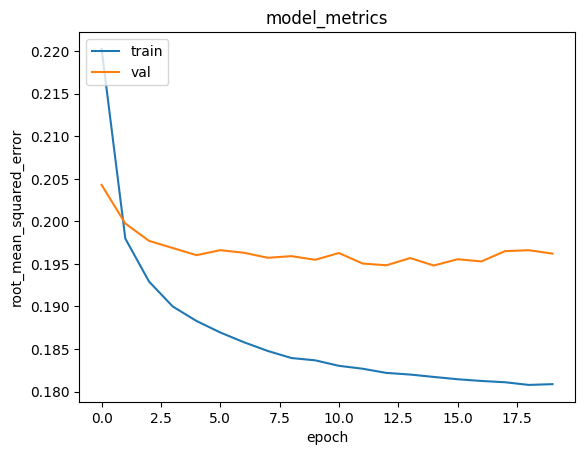

In [84]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Berdasarkan plot tersebut, proses training model berhenti pada epoch ke 15 (epochs 1 dimulai dari nomor 0 pada plot) karena `callbacks` yang berisi `early stopper`. `early stopper` menghentikan proses training karena model tidak menunjukkan penurunan yang lebih keci dari `val_root_mean_squared_error` pada epochs ke-15 selama 5 epochs berturut-turut.

Kemudian, model pada epochs ke 15 yang dipertahankan karena pada epochs tersebut model memiliki performa yang terbaik. Berikut adalah hasil dari metriks pada epocs tersebut:
- `loss` : 0.5912
- `root_mean_squared_error` : 0.1817
- `val_loss` : 0.6025
- `val_root_mean_squared_error` : 0.1948